In [6]:
import os
import sys

path = os.getcwd()
while os.path.basename(os.path.normpath(path)) != 'roman-pandeia':
    path = os.path.dirname(path)
repo_path = path
if repo_path not in sys.path:
    sys.path.append(repo_path)

In [7]:
import os
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib
from hydra import initialize, compose
from glob import glob

from package.plots import diagnostic_plot, plot

plt.style.use(f'{repo_path}/package/mplstyle/science.mplstyle')

In [8]:
with initialize(version_base=None, config_path='../../config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, repo_dir = config.machine.array_dir, config.machine.data_dir, config.machine.repo_dir

figure_dir = os.path.join(repo_dir, 'figures')
array_dir = os.path.join(array_dir, 'test_physical_lens')

In [9]:
array_files = glob(array_dir + '/*0.npy')
array_list = [np.load(i) for i in array_files]

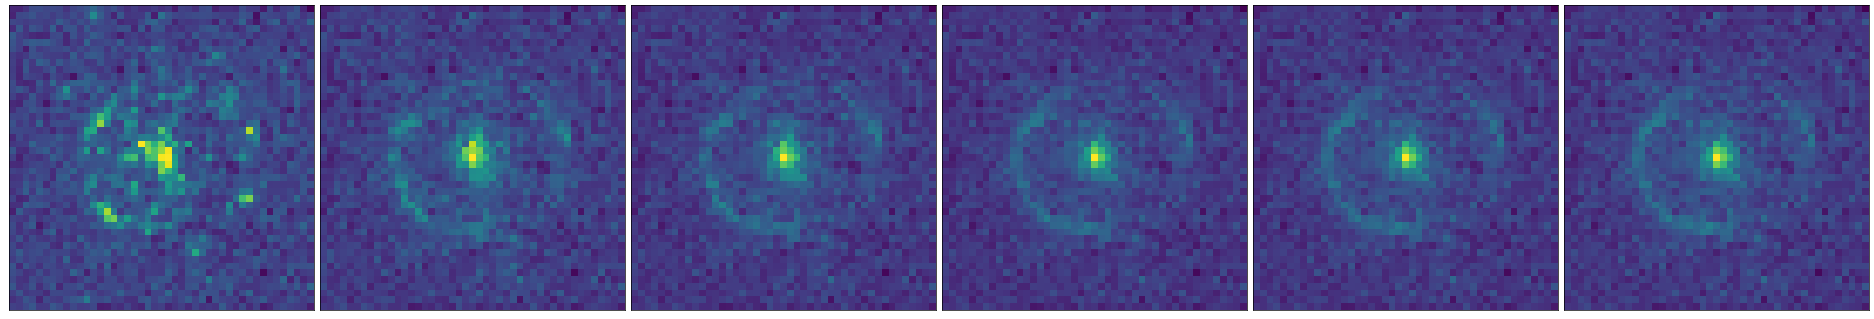

In [10]:
plot.plot_list(array_list)

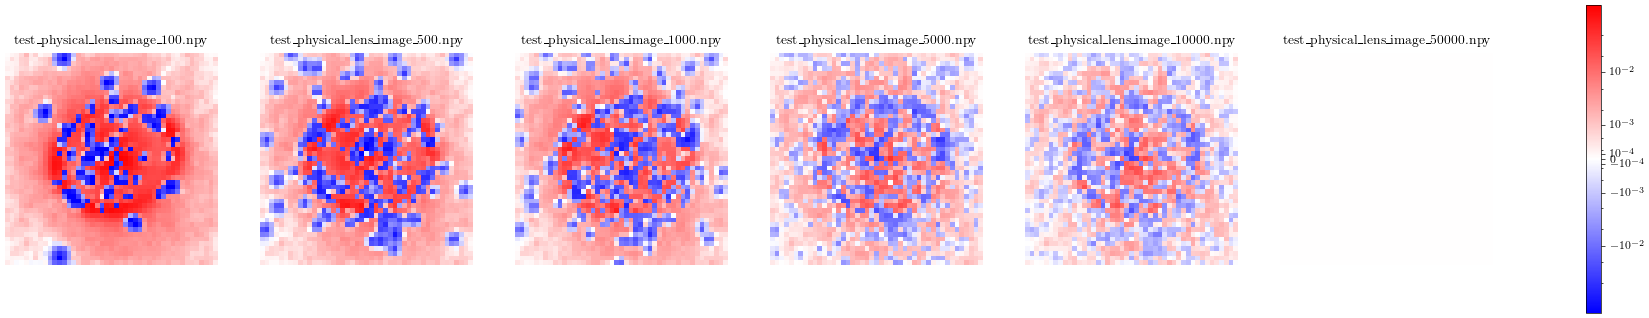

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=len(array_list), figsize=(len(array_list) * 4, 4))
matplotlib.rcParams.update({'font.size': 8})

last_array = array_list[-1]
residual_list = [(last_array - i) for i in array_list]
title_list = [os.path.basename(i) for i in array_files]

axis = diagnostic_plot.residual_compare(ax, residual_list, title_list, linear_width=0.0005)

fig.colorbar(axis, ax=ax, ticks=[-0.01, -0.001, -0.0001, 0, 0.0001, 0.001, 0.01])

plt.savefig(os.path.join(figure_dir, 'oversampling.png'))
plt.show()